In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
import io
import seaborn as sns

from sklearn.utils import shuffle # Shuffle arrays or sparse matrices in a consistent way
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard,ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import plot_model

import ipywidgets as widgets
from PIL import Image
from IPython.display import display, clear_output

In [3]:
labels = ['CONTROL', 'AD', 'PD']

In [4]:
X_train = [] #Training Dataset
Y_train = [] #Training Labels

image_size=150

for i in labels:
    folderPath = os.path.join('3_cls/', 'train', i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
        
for i in labels:
    folderPath = os.path.join('3_cls/', 'test', i) # Join two or more pathname components
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
#Image and Label is appended as list, now is to be converted into array
X_train = np.array(X_train)
Y_train = np.array(Y_train)

100%|██████████| 61/61 [00:01<00:00, 44.77it/s]


In [5]:
X_train.shape

(7839, 150, 150, 3)

In [6]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

In [7]:
#After shuffling sample size remains same
X_train.shape

(7839, 150, 150, 3)

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [9]:
y_train_new = []
y_test_new = []

for i in Y_train:
    y_train_new.append(labels.index(i))#Converting String Label to integer i.e
                                       # CONTROL ---> 0, AD---> 1, PD ---> 2
Y_train = to_categorical(y_train_new) #Converts a class vector (integers) to binary class matrix

for i in Y_test:
    y_test_new.append(labels.index(i))

Y_test = to_categorical(y_test_new)

In [10]:
Y_train

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [11]:
# Input of model
efficientnet_B0 = EfficientNetB0(include_top=False,
    weights='imagenet',
    input_shape=(image_size, image_size, 3))

In [12]:
# Output of model
model = efficientnet_B0.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(3, activation='softmax')(model)

In [13]:
#Merge input and Output of model
model = tf.keras.models.Model(inputs=efficientnet_B0.input, outputs=model)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 150, 150, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 150, 150, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 150, 150, 3)          0         ['normalization[0][0]']   

In [14]:
#Configures the model for training
model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc'])

In [15]:
tensorBoard = TensorBoard(log_dir="logs")
checkPoint = ModelCheckpoint("efficient_net_B0.h5",
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True,
                            mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                             factor=0.3,
                             patience=2,
                             verbose=1,
                             mode='auto',
                             min_delta=0.001)
es = EarlyStopping(monitor='val_loss',
                   patience=5,
                   verbose=1,
                   mode='auto',
                   restore_best_weights=True) 

In [16]:
history = model.fit(X_train, 
                    Y_train,
                    batch_size=32,
                    validation_split=0.1,
                    epochs=20,
                    verbose=1,
                    callbacks=[tensorBoard, checkPoint, reduce_lr, es])

Epoch 1/20
199/199 [==============================] - ETA: 0s - loss: 0.5801 - acc: 0.7229
Epoch 1: val_loss improved from inf to 0.41113, saving model to efficient_net_B0.h5


c:\Users\megha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


199/199 [==============================] - 659s 3s/step - loss: 0.5801 - acc: 0.7229 - val_loss: 0.4111 - val_acc: 0.8130 - lr: 0.0010
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.3350 - acc: 0.8518
Epoch 2: val_loss improved from 0.41113 to 0.33473, saving model to efficient_net_B0.h5
199/199 [==============================] - 643s 3s/step - loss: 0.3350 - acc: 0.8518 - val_loss: 0.3347 - val_acc: 0.8470 - lr: 0.0010
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.2022 - acc: 0.9197
Epoch 3: val_loss did not improve from 0.33473
199/199 [==============================] - 674s 3s/step - loss: 0.2022 - acc: 0.9197 - val_loss: 0.4447 - val_acc: 0.8187 - lr: 0.0010
Epoch 4/20
199/199 [==============================] - ETA: 0s - loss: 0.1411 - acc: 0.9447
Epoch 4: val_loss improved from 0.33473 to 0.25002, saving model to efficient_net_B0.h5
199/199 [==============================] - 678s 3s/step - loss: 0.1411 - acc: 0.9447 - val_loss: 0.

In [17]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
actual_label = np.argmax(Y_test, axis=1)
print(classification_report(actual_label, pred))

25/25 [==============================] - 27s 925ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       360
           1       0.99      0.99      0.99       317
           2       0.95      0.91      0.93       107

    accuracy                           0.98       784
   macro avg       0.97      0.96      0.97       784
weighted avg       0.98      0.98      0.98       784



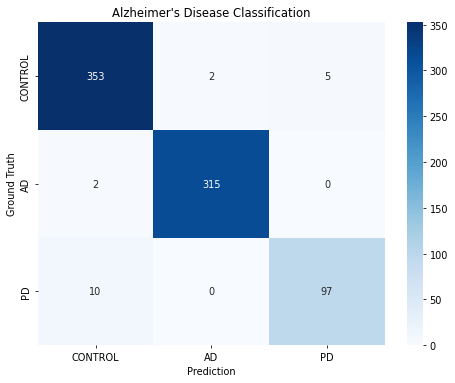

In [18]:
cnf = confusion_matrix(actual_label, pred)
plt.figure(figsize=(8,6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(cnf, cmap='Blues',annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Alzheimer\'s Disease Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)

In [19]:
saved_model = tf.keras.models.load_model("./efficient_net_B0.h5")

#Show Model Architecture
plot_model(saved_model,
          to_file='efficient_net_B0.png',
          show_shapes=True,
          show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [42]:
model.output_shape

(None, 3)